# Домашнее задание 3

В этом задании напишем простое решение классификации датасета `FashionMNIST`, а затем будем его улучшать с помощью:
- dropout;
- batch normalization;
- LR scheduler;

В конце сохраним модель в файл и убедимся, что этот файл можем в дальнейшем прочитать.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from dataclasses import dataclass

In [2]:
train_dataset = FashionMNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
test_dataset = FashionMNIST(
    root="./data", train=False, download=True, transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]


In [3]:
X_train = train_dataset.data.float()
y_train = train_dataset.targets
X_test = test_dataset.data.float()
y_test = test_dataset.targets

In [ ]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# Визуализируем датасет
import matplotlib.pyplot as plt
import numpy as np


In [6]:
# инициализируем случайный генератор
rng = np.random.default_rng(seed=42)

arr = np.arange(X_train.shape[0])
print(arr[:10])
rng.shuffle(arr)
print(arr[:10])

[0 1 2 3 4 5 6 7 8 9]
[ 3493 57546  8815 19332 15566 22963 21972 22093  1818 46044]


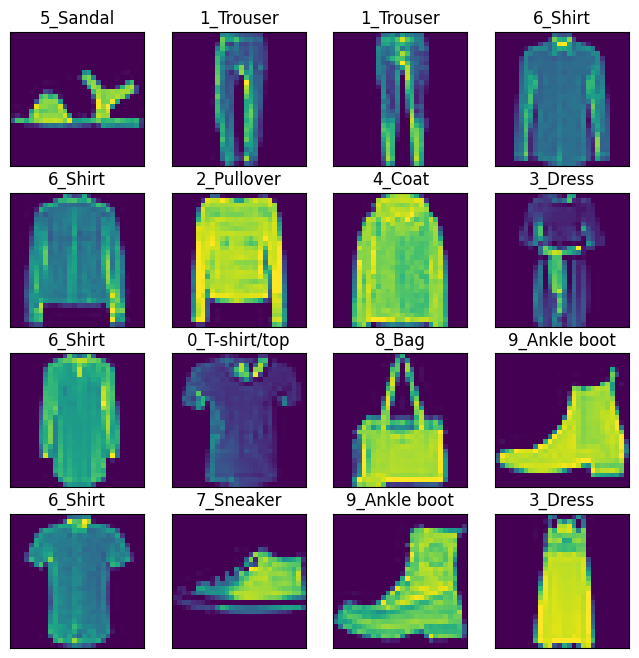

In [7]:
# инициализируем случайный генератор
rng = np.random.default_rng(seed=40)
arr = np.arange(X_train.shape[0])
rng.shuffle(arr)

# визуализируем данные
classes = train_dataset.classes

n = 4
fig, ax = plt.subplots(n, n, figsize=(8, 8))
for row in range(n):
    for col in range(n):
        idx = arr[n*row + col]
        ax[row][col].imshow(X_train[idx])
        ax[row][col].set_title(f"{y_train[idx]}_{classes[y_train[idx]]}")
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

In [8]:
@dataclass
class TrainConfig:
    lr: float = 1e-3
    total_iterations: int = 100
    eval_every: int = 10


# Для оценки будем использовать метрику accuracy
# Подумайте (опционально), какие еще метрики можно использовать
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

## Задание №1

Попробуйте реализовать простой бейзлайн с несколькими слоями:
- Linear
- ReLU
- Linear

Организуйте слои в nn.Sequential переменную с названием net (т.е. ваш класс должен иметь атрибут self.net). Вам нужно дописать и сдать как `SimpleModel`, так и `train_loop`.
Используйте кросс-энтропию как функцию потерь.

In [8]:
import wandb
import tqdm

In [ ]:
# попробуем на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

class SimpleModel(nn.Module):
    def __init__(self, num_classes: int = 10):
        """
        Args:
            num_classes: Количество классов для классификации
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            # nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


def train_loop(
    model: SimpleModel,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    """Обучите здесь модель, подсчитайте метрики на валидационной выборке.

    Можете так же писать/рисовать accuracy в процессе обучения.
    Например, каждые 10 итераций или даже каждую итерацию.
    """
    # wandb.init(
    #     project="Fashion-model-train",
    #     notes="version 1",
    #     tags=["sgd", "2-layer"],
    #     config=config,
    # )
    # Оставьте такое название перменной, это требование проверяющей системы
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    # Перекинем на GPU при наличии
    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    # Ваш код обучения модели
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optimizer.zero_grad()
        
        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optimizer.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}

        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item()})
    #     wandb.log(metrics)
    # wandb.finish()
    return metrics

torch.random.manual_seed(42)
config = TrainConfig()
model = SimpleModel(num_classes=len(train_dataset.classes))
metrics = train_loop(model, X_train, y_train, X_test, y_test, config=config)        


Используем cuda


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


In [16]:
print(metrics)

{'iteration': 99, 'loss_train': 0.6508684158325195, 'loss_val': 0.7121248245239258}


## Задание №2
Какое максимальное значение метрики accuracy удалось получить в процессе обучения на **тестовой** выборке?

Округлите до 3 значений после запятой


In [17]:
torch.manual_seed(987)
# дефолтные значения
config = TrainConfig()
# Ваш код для обучения и подсчета accuracy

# попробуем на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

class SimpleModel(nn.Module):
    def __init__(self, num_classes: int = 10):
        """
        Args:
            num_classes: Количество классов для классификации
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            # nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


def train_loop(
    model: SimpleModel,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    """Обучите здесь модель, подсчитайте метрики на валидационной выборке.

    Можете так же писать/рисовать accuracy в процессе обучения.
    Например, каждые 10 итераций или даже каждую итерацию.
    """
    wandb.init(
        project="Fashion-model-train",
        notes="version 2 no Softmax",
        tags=["sgd", "2-layer"],
        config=config,
    )
    # Оставьте такое название перменной, это требование проверяющей системы
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    # Перекинем на GPU при наличии
    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    # Ваш код обучения модели
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optimizer.zero_grad()
        
        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optimizer.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}

        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item()})
        wandb.log(metrics)
    wandb.finish()
    return metrics

# torch.random.manual_seed(42)
# config = TrainConfig()
# model = SimpleModel(num_classes=len(train_dataset.classes))
# metrics = train_loop(model, X_train, y_train, X_test, y_test, config=config) 


Используем cuda


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


iteration,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
loss_train,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▅▄▃▂▂▂▁▁▁
iteration,99
loss_train,0.65087
loss_val,0.71212


In [19]:
y_pred = model.cpu()(X_test)
calculate_accuracy(y_pred, y_true=y_test)

0.7770000100135803

## Задание №3
Добавьте один `dropout` слой в вашу модель.

_Подумайте, что может поменяться при перестановке ReLU и Dropout слоев местами._

In [20]:
@dataclass
class TrainConfig:
    lr: float = 1e-3
    total_iterations: int = 100
    eval_every: int = 10
    dropout_rate: float = 0


# Для оценки будем использовать метрику accuracy
# Подумайте (опционально), какие еще метрики можно использовать
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

# попробуем на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

class DropoutModel(nn.Module):

    def __init__(self, num_classes=10, dropout_rate=0.2):
        """
        Args:
            num_classes: Количество классов для классификации
            dropout_rate: Вероятность отключения нейронов
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
            # nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


def train_loop(
    model: DropoutModel,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    """Обучите здесь модель, подсчитайте метрики на валидационной выборке.

    Можете так же писать/рисовать accuracy в процессе обучения.
    Например, каждые 10 итераций или даже каждую итерацию.
    """
    wandb.init(
        project="Fashion-model-train",
        notes="version 1",
        name=f"Dropput={config.dropout_rate}_iters={config.total_iterations}",
        tags=["sgd", "2-layer-Dropout"],
        config=config,
    )
    # Оставьте такое название перменной, это требование проверяющей системы
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    # Перекинем на GPU при наличии
    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    # Ваш код обучения модели
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optimizer.zero_grad()
        
        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optimizer.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}

        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                acc_train = calculate_accuracy(model(X_train_dev), y_train_dev)
                acc_val = calculate_accuracy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item(), 
                                "accuracy_train": acc_train,
                                "accuracy_val": acc_val})
        wandb.log(metrics)
    wandb.finish()
    return metrics
    

torch.manual_seed(987)
dropout_rate=0.2
config = TrainConfig(dropout_rate=dropout_rate, total_iterations=500)
model = DropoutModel(num_classes=len(train_dataset.classes), dropout_rate=dropout_rate)
metrics = train_loop(model, X_train, y_train, X_test, y_test, config=config)   


Используем cuda


100%|██████████| 500/500 [01:33<00:00,  5.38it/s]


accuracy_train,▁▃▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
accuracy_val,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
iteration,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
loss_train,█▇▆▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_train,0.84012
accuracy_val,0.8211
iteration,499
loss_train,0.5234
loss_val,0.52109


## Задание №4
Какое максимальное значение accuracy получилось в ходе обучения модели на **тестовой** выборке?

Округлите до 3х знаков после запятой и отправьте в ЛМС.

In [14]:
torch.manual_seed(987)
config = TrainConfig()
# Ваш код для обучения и подсчета accuracy
model = DropoutModel(num_classes=len(train_dataset.classes))
metrics = train_loop(model, X_train, y_train, X_test, y_test, config=config) 
y_pred = model.cpu()(X_test)
calculate_accuracy(y_pred, y_true=y_test)

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
loss_train,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▅▄▃▂▂▂▁▁▁
iteration,99
loss_train,0.76053
loss_val,0.70459


0.7515000104904175

## Задание №5

Добавьте `BatchNorm` в вашу модель.
Отправьте в ЛМС реализацию.

Стоит ли делать BatchNorm до ReLU или после него?
Это дискуссионный вопрос, чаще всего применяют сначала нелинейность, затем Batch Norm.
Один из аргументов: при таком подходе данные на выходе будут иметь среднее 0 - что и ожидают люди, когда добавляют нормализацию.

_[Дискуссия на Reddit](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)_

Для определенности в этом задании будем следовать такому порядку: сначала ReLU, затем Batch Norm.

In [ ]:
class BatchNormModel(nn.Module):

    def __init__(self, num_classes=10):
        """
        Args:
            num_classes: Количество классов для классификации
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)

In [24]:
nn.BatchNorm1d??

Init signature: nn.BatchNorm1d(self, *args, **kwargs)
Source:        
class BatchNorm1d(_BatchNorm):
    r"""Applies Batch Normalization over a 2D or 3D input.

    Method described in the paper
    `Batch Normalization: Accelerating Deep Network Training by Reducing
    Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .

    .. math::

        y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

    The mean and standard-deviation are calculated per-dimension over
    the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
    of size `C` (where `C` is the number of features or channels of the input). By default, the
    elements of :math:`\gamma` are set to 1 and the elements of :math:`\beta` are set to 0.
    At train time in the forward pass, the variance is calculated via the biased estimator,
    equivalent to ``torch.var(input, unbiased=False)``. However, the value stored in the
    moving average of the va

In [ ]:
torch.manual_seed(987)
config = TrainConfig()
# Ваш код для обучения и подсчета accuracy

## Задание №6
Какое максимальное значение `accuracy` получилось в ходе обучения модели на **тестовой** выборке?

Округлите до 3х знаков после запятой.

In [23]:
@dataclass
class TrainConfig:
    lr: float = 1e-3
    total_iterations: int = 100
    eval_every: int = 10
    dropout_rate: float = 0


# Для оценки будем использовать метрику accuracy
# Подумайте (опционально), какие еще метрики можно использовать
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

# попробуем на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

class BatchNormModel(nn.Module):

    def __init__(self, num_classes=10):
        """
        Args:
            num_classes: Количество классов для классификации
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


def train_loop_batchnorm(
    model: BatchNormModel,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    """Обучите здесь модель, подсчитайте метрики на валидационной выборке.

    Можете так же писать/рисовать accuracy в процессе обучения.
    Например, каждые 10 итераций или даже каждую итерацию.
    """
    wandb.init(
        project="Fashion-model-train",
        notes="version 1",
        name=f"BatchNorm_iters={config.total_iterations}_lr={config.lr}",
        tags=["sgd", "2-layer-BatchNorm"],
        config=config,
    )
    # Оставьте такое название перменной, это требование проверяющей системы
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    # Перекинем на GPU при наличии
    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    # Ваш код обучения модели
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optimizer.zero_grad()
        
        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optimizer.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}

        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                acc_train = calculate_accuracy(model(X_train_dev), y_train_dev)
                acc_val = calculate_accuracy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item(), 
                                "accuracy_train": acc_train,
                                "accuracy_val": acc_val})
        wandb.log(metrics)
    wandb.finish()
    return metrics
    

torch.manual_seed(987)
config = TrainConfig(lr=1e-2, total_iterations=500)
model = BatchNormModel(num_classes=len(train_dataset.classes))
metrics = train_loop_batchnorm(model, X_train, y_train, X_test, y_test, config=config)   


Используем cuda


100%|██████████| 500/500 [01:32<00:00,  5.42it/s]


accuracy_train,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
accuracy_val,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇██████
loss_train,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_train,0.86717
accuracy_val,0.8494
iteration,499
loss_train,0.38968
loss_val,0.43386


Результат batch normalization мог не особо порадовать.
Но не спешите с выводами насчет этого слоя!

Попробуйте обучить заново все три модели со значением `lr=1e-2` (в 10 раз больше).
Сравните результаты моделей и сделайте вывод.

## Задание №7
Добавьте `LRscheduler` в вашу модель.

Подробнее про `schedulers` можно почитать в [документации](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [ ]:
from torch.optim.lr_scheduler import StepLR


def train_loop_with_scheduler(
    model,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
):
    # wandb.init(
    #     project="Fashion-model-train",
    #     notes="version 1",
    #     name=f"BatchNorm_iters={config.total_iterations}_lr={config.lr}",
    #     tags=["sgd", "2-layer-BatchNorm"],
    #     config=config,
    # )
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    # Перекинем на GPU при наличии
    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)

    # Зададим scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.95)

    # Ваш код обучения модели
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optimizer.zero_grad()
        
        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optimizer.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}

        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                acc_train = calculate_accuracy(model(X_train_dev), y_train_dev)
                acc_val = calculate_accuracy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item(), 
                                "accuracy_train": acc_train,
                                "accuracy_val": acc_val})
        scheduler.step()
    #     wandb.log(metrics)
    # wandb.finish()


In [ ]:
torch.manual_seed(987)
config = TrainConfig(lr=1e-3)
# Ваш код для обучения и подсчета accuracy

## Задание №8

Поэксперементируйте с параметрами нейронной сети, попробуйте добиться максимальной метрики `accuracy`.

- попробуйте комбинацию Dropout + Batch Normalization и подумайте, как лучше всего раскрыть силу Batch Normalization (вспомните эксперименты с lr);
- попробуйте подвигать вероятность в Dropout;
- ну, или подержите обучение подольше, поставив больше шагов :)

В ЛМС нужно сдать код класса `ExpModel`.
Вам необходимо выбить accuracy > 80%, чтобы сдать этот пункт.

In [9]:
from torch.optim.lr_scheduler import StepLR

@dataclass
class TrainConfig:
    lr: float = 1e-3
    total_iterations: int = 500
    eval_every: int = 10
    dropout_rate: float = 0


# Для оценки будем использовать метрику accuracy
# Подумайте (опционально), какие еще метрики можно использовать
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

# попробуем на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

class ExpModel(nn.Module):

    def __init__(self, num_classes=10, dropout_rate=0.2):
        """
        Args:
            num_classes: Количество классов для классификации
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)


def train_loop_exp(
    model: ExpModel,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    config: TrainConfig,
    run_name: str | None = None,
):
    """Обучите здесь модель, подсчитайте метрики на валидационной выборке.

    Можете так же писать/рисовать accuracy в процессе обучения.
    Например, каждые 10 итераций или даже каждую итерацию.
    """
    wandb.init(
        project="Fashion-model-train",
        notes="version 1",
        name=f"{run_name}",
        tags=["sgd", "2-layer"],
        config=config,
    )
    # Оставьте такое название перменной, это требование проверяющей системы
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    # Перекинем на GPU при наличии
    X_val_dev = X_val.clone().to(device)
    y_val_dev = y_val.clone().to(device)
    
    # Зададим scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.95)
    # Ваш код обучения модели
    model = model.to(device)
    model.train()
    for i in tqdm.trange(config.total_iterations):
        optimizer.zero_grad()
        
        X_train_dev = X_train.clone().to(device)
        y_train_dev = y_train.clone().to(device)      

        loss = F.cross_entropy(model(X_train_dev), y_train_dev)
        loss.backward()
        optimizer.step()
        metrics = {"iteration": i, "loss_train": loss.detach().cpu().item()}

        if (i + 1) % config.eval_every == 0:
            with torch.no_grad():
                model.eval()
                loss_val = F.cross_entropy(model(X_val_dev), y_val_dev)
                acc_train = calculate_accuracy(model(X_train_dev), y_train_dev)
                acc_val = calculate_accuracy(model(X_val_dev), y_val_dev)
                model.train()
                metrics.update({"loss_val": loss_val.cpu().item(), 
                                "accuracy_train": acc_train,
                                "accuracy_val": acc_val})
        scheduler.step()
        wandb.log(metrics)
    wandb.finish()
    return metrics
    

torch.manual_seed(987)
lr = 0.1
dropout_rate = 0
config = TrainConfig(lr=lr, dropout_rate=dropout_rate)
model = ExpModel(num_classes=len(train_dataset.classes), dropout_rate=dropout_rate)
metrics = train_loop_exp(model, X_train, y_train, X_test, y_test, config=config, 
                         run_name=f"lr_{lr}_drop_{dropout_rate}_batchnorm_stepshed_10_0.95")   

Используем cuda


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a-s-kurdyubov (a-s-kurdyubov-spbu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


accuracy_train,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████████████████
accuracy_val,▁▃▄▆▅▇▇▇▇▇▇▇████████████████████████████
iteration,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇████
loss_train,█▇▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_val,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy_train,0.90415
accuracy_val,0.8743
iteration,499
loss_train,0.2766
loss_val,0.35857


Наконец, сохраним лучшую модель, чтобы в будущем ее могли взять и использовать, без обучения.

## Задание №9

Напишите код, который сохранит модель в файл `model.pt`.

In [11]:
# подключим google drive
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/ExpModel_3.pt")

Mounted at /content/drive


In [3]:
# Впоследствии эту модель можно будет загрузить вот так:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from dataclasses import dataclass

train_dataset = FashionMNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
test_dataset = FashionMNIST(
    root="./data", train=False, download=True, transform=ToTensor()
)

X_train = train_dataset.data.float()
y_train = train_dataset.targets
X_test = test_dataset.data.float()
y_test = test_dataset.targets

def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()

class ExpModel(nn.Module):

    def __init__(self, num_classes=10, dropout_rate=0.2):
        """
        Args:
            num_classes: Количество классов для классификации
        """
        super().__init__()
        # Размерность скрытого слоя
        hidden_dim = 512

        self.net = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((-1, 28 * 28))
        return self.net(x)

model_loaded = ExpModel(num_classes=len(y_test.unique()))
model_loaded.load_state_dict(torch.load("ExpModel_3.pt", map_location='cpu'))

y_pred_train = model_loaded(X_train)
y_pred_test = model_loaded(X_test)

print("Train accuracy:", calculate_accuracy(y_pred_train, y_train))
print("Test accuracy:", calculate_accuracy(y_pred_test, y_test))

Train accuracy: 0.8920166492462158
Test accuracy: 0.8640999794006348
